In [1]:
import pandas as pd
import numpy as np
import os
import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import s3_input, Session

In [2]:
#Download from github and extract
!wget -N https://github.com/joechoong33/LC_loan/zipball/master
!unzip -o master
!unzip -o joechoong33-LC_loan-70a9ba3/DS-02-lendingclub-loan-data-2017q1.zip

--2020-09-24 07:52:19--  https://github.com/joechoong33/LC_loan/zipball/master
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/joechoong33/LC_loan/legacy.zip/master [following]
--2020-09-24 07:52:19--  https://codeload.github.com/joechoong33/LC_loan/legacy.zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master’

master                  [       <=>          ]  30.88M  22.5MB/s    in 1.4s    

Last-modified header missing -- time-stamps turned off.
2020-09-24 07:52:22 (22.5 MB/s) - ‘master’ saved [32385856]

Archive:  master
ecae133802241a816be9b593246ea89fe52caaca
 extracting: joechoong33-LC_loan-ecae133/DS-02 len

In [3]:
df = pd.read_csv('lpetrocelli-lendingclub-loan-data-2017-q-1/LoanStats_2017Q1 2.csv',skiprows = 1)
df.shape

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,112) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(96781, 122)

In [4]:
df_loan = df[:-2]
df_loan.tail(2)
df['int_rate'] = df['int_rate'].str.replace('%','')
df['int_rate'] = pd.to_numeric(df['int_rate'],errors='coerce')

In [5]:
# Categorize employment length
def emp_to_num(term):
    if pd.isna(term):
        return None
    elif term[2]=='+':
        return 10
    elif term[0]=='<':
        return 0
    else:
        return int(term[0])

df['emp_length_num'] = df['emp_length'].apply(emp_to_num)

In [6]:
#Feature engineer - basically lender credit status
df.loc[:, 'flag'] = np.where((df.purpose == 'debt_consolidation') | (df.purpose == 'credit_card'),1.0, -1.0)
df['install_loan_ratio'] = (df['installment'] / df['loan_amnt']) * 100
df['long_emp'] = df['emp_length'].apply(lambda x: 1*(x=='10+ years'))
df['short_emp'] = df['emp_length'].apply(lambda x: 1*(x=='1 year' or x=='< 1 year'))


In [7]:
df['loan_status'].value_counts()

Current               78897
Issued                15071
Fully Paid             2251
In Grace Period         330
Late (31-120 days)      126
Late (16-30 days)       104
Name: loan_status, dtype: int64

In [8]:
#Predict for good and bad - map loan status into 0 and 1
df['target']=df['loan_status'].map({'Current': 1,'Issued': 1, 'Fully Paid': 1, 'In Grace Period': 0, 'Late (31-120 days)':0, 'Late (16-30 days)': 0})

In [9]:
# Huge class imbalance
df['target'].value_counts(normalize=True)

1.0    0.994214
0.0    0.005786
Name: target, dtype: float64

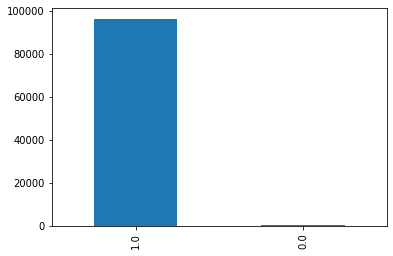

In [10]:
# Huge class imbalance
df['target'].value_counts().plot(kind='bar')

In [11]:
#tranform annual income to log
df['annual_inc_log'] = df['annual_inc'].apply(np.log)

In [12]:
columns = ['loan_amnt', 'term', 'int_rate','flag','install_loan_ratio',
       'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc_log', 'verification_status',
       'target', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc']
df = df[columns]

df.dropna(inplace=True)

In [13]:
# Map grade to integer
df['grade']=df['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

In [14]:
#Copy dataframe
df_dummies = pd.get_dummies(df) 

In [15]:
drop_columns = df_dummies.columns[(df_dummies.mean()<0.01)]
df_dummies.drop(drop_columns, axis=1, inplace=True)

In [16]:
df_dummies['verification_status_Verified_sum'] = df_dummies['verification_status_Source Verified']+df_dummies['verification_status_Verified']
df_dummies.drop(['verification_status_Source Verified', 'verification_status_Verified'], axis=1, inplace=True)


df_dummies = df_dummies.rename(columns={'emp_length_10+ years':'emp_length_10 years','emp_length_< 1 year':'emp_length_less 1 year'})

In [18]:
X = df_dummies.copy()
X = pd.concat([X['target'], X.drop(['target'], axis=1)], axis=1) 

In [19]:
#Drop zip code of states
drop_list1 = ['addr_state_AL',
       'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT',
       'addr_state_FL', 'addr_state_GA', 'addr_state_IL', 'addr_state_IN',
       'addr_state_LA', 'addr_state_MA', 'addr_state_MD', 'addr_state_MI',
       'addr_state_MN', 'addr_state_MO', 'addr_state_NC', 'addr_state_NJ',
       'addr_state_NV', 'addr_state_NY', 'addr_state_OH', 'addr_state_OR',
       'addr_state_PA', 'addr_state_SC', 'addr_state_TN', 'addr_state_TX',
       'addr_state_VA', 'addr_state_WA', 'addr_state_WI']

X.drop(drop_list1,axis=1,inplace=True)

In [20]:
X['target'] = X['target'].astype(int)

In [21]:
X.head()

,target,loan_amnt,int_rate,flag,install_loan_ratio,installment,grade,dti,delinq_2yrs,inq_last_6mths,...,verification_status_Not Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business,verification_status_Verified_sum
0,1,3600.0,7.49,-1.0,3.110278,111.97,1,18.90,0.0,1.0,...,1,0,0,0,0,0,0,1,0,0
1,1,15000.0,14.99,-1.0,2.378533,356.78,3,17.25,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
2,1,8400.0,11.39,-1.0,3.292381,276.56,2,15.63,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
3,1,4000.0,10.49,-1.0,3.250000,130.00,2,33.61,1.0,0.0,...,0,0,0,0,0,1,0,0,0,1
4,1,6000.0,7.24,1.0,3.098833,185.93,1,9.25,0.0,1.0,...,0,0,1,0,0,0,0,0,0,1


In [19]:
#X = X.iloc[:,:10]
#X.head()

,target,loan_amnt,int_rate,flag,install_loan_ratio,installment,grade,dti,delinq_2yrs,inq_last_6mths
0,1,3600.0,7.49,-1.0,3.110278,111.97,1,18.90,0.0,1.0
1,1,15000.0,14.99,-1.0,2.378533,356.78,3,17.25,0.0,0.0
2,1,8400.0,11.39,-1.0,3.292381,276.56,2,15.63,0.0,0.0
3,1,4000.0,10.49,-1.0,3.250000,130.00,2,33.61,1.0,0.0
4,1,6000.0,7.24,1.0,3.098833,185.93,1,9.25,0.0,1.0


In [20]:
train_data, validation_data, test_data = np.split(X.sample(frac=1, random_state=1729), [int(0.7 * len(X)), int(0.9 * len(X))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [21]:
train_data

,target,loan_amnt,int_rate,flag,install_loan_ratio,installment,grade,dti,delinq_2yrs,inq_last_6mths
56276,1,20000.0,18.99,1.0,2.593550,518.71,4,28.78,0.0,0.0
26454,1,8500.0,10.49,1.0,3.249882,276.24,2,17.62,0.0,0.0
65620,1,14000.0,12.74,1.0,2.262071,316.69,3,25.73,0.0,1.0
58773,1,5275.0,22.74,1.0,3.857441,203.48,5,2.58,0.0,0.0
61515,1,4200.0,10.49,1.0,3.250000,136.50,2,14.06,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...
56835,1,35000.0,30.79,1.0,3.284057,1149.42,7,29.14,0.0,0.0
79584,1,2000.0,8.24,1.0,3.145000,62.90,2,18.27,0.0,0.0
43860,1,15000.0,15.99,1.0,3.515267,527.29,3,12.09,0.0,0.0
54096,1,30000.0,14.99,1.0,3.466067,1039.82,3,15.07,0.0,1.0


In [59]:
bucket = 'lcloan3'
prefix = 'loan'
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [60]:
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta"
        },
        {
          "MaxValue": "2",
          "MinValue": "0",
          "Name": "alpha"
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 20,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:auc",
      "Type": "Maximize"
    }
  }

In [61]:
region = boto3.session.Session().region_name
region

from sagemaker import get_execution_role
region = 'us-west-2'
#region = 'ap-southeast-1'
role = get_execution_role()

In [62]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(region, 'xgboost', repo_version='1.0-1')
region = boto3.session.Session().region_name

s3_input_train = 's3://{}/{}/train'.format(bucket, prefix)
s3_input_validation ='s3://{}/{}/validation/'.format(bucket, prefix)

training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": training_image,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_train
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_validation
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/output".format(bucket,prefix)
    },
    "ResourceConfig": {
      "InstanceCount": 2,
      "InstanceType": "ml.c4.2xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "auc",
      "num_round": "100",
      "objective": "binary:logistic",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 3600
    }
}

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [64]:
#Execute tuning
smclient = boto3.client(service_name='sagemaker')
tuning_job_name = "LoanModelTuning4"
smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-west-2:875644041935:hyper-parameter-tuning-job/loanmodeltuning4',
 'ResponseMetadata': {'RequestId': '044f9a40-24f3-4898-a9d5-0186ed329810',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '044f9a40-24f3-4898-a9d5-0186ed329810',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '117',
   'date': 'Thu, 24 Sep 2020 03:56:34 GMT'},
  'RetryAttempts': 0}}

In [ ]:
#END